In [1]:
import numpy as np
import matplotlib.pyplot as plt
import block
import mdtraj as md
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.optimize import curve_fit
import pickle5 as pickle
import pandas as pd

In [2]:
#Make colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

new_cmap = ['#A6CEE3','#1F78B4','#B2DF8A','#33A02C','#FB9A99','#E31A1C','#FDBF6F','#FF7F00','#CAB2D6','#6A3D9A','#ECEC28','#B15928']
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,12))

# Lists and dictionaries

In [3]:
#List of proteins
proteins = ['K25', 'A1', 'CoRNID', 'ColNT', 'FhuA', 'Hst52', 'K19', 'PNt', 'Sic1', 'aSyn', 'Hst5', 'ACTR']

#List of proteins only simulated for PRE data
PRE_proteins = ['FUS', 'A2']

#List of lambdas
lambdas = ['1.00', '1.04', '1.06', '1.08', '1.10', '1.12', '1.14']
lambdas_float = [1.0, 1.04, 1.06, 1.08, 1.10, 1.12, 1.14]

#Cut-off for tolerable periodic image distance
PI_distance_cutoff = 1.1

#Automatic block-size selection method for block-error analysis
errmethod='hline' #Choose b3, hline or knee_loc

#Dictionary with protein experimental Rg and error: [exp_Rg, exp_err]
exp_Rg = {'PNt': [4.96, 0.56], 'Sic1': [2.86, 0.14], 'Hst5':[1.34, 0.05], 'ACTR':[2.55, 0.27], 'K25': [4.06, 0.28], 'A1': [2.55, 0.1], 'CoRNID': [4.72, 0.12], 'ColNT':[2.82, 0.034], 'FhuA':[3.21, 0.22], 'Hst52':[1.77, 0.049], 'K19':[3.35, 0.29], 'aSyn':[3.56, 0.036]}

#Dictionary with protein lengths (residues)
nr_residues = {'PNt':334, 'Sic1':92, 'Hst5':24, 'ACTR':71, 'K25':185, 'A1':137, 'CoRNID':271, 'ColNT':98, 'FhuA':144, 'Hst52':48, 'K19':99, 'aSyn':140}

# Plot Rg vs lambda

/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )
/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )
/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )
/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )
/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1

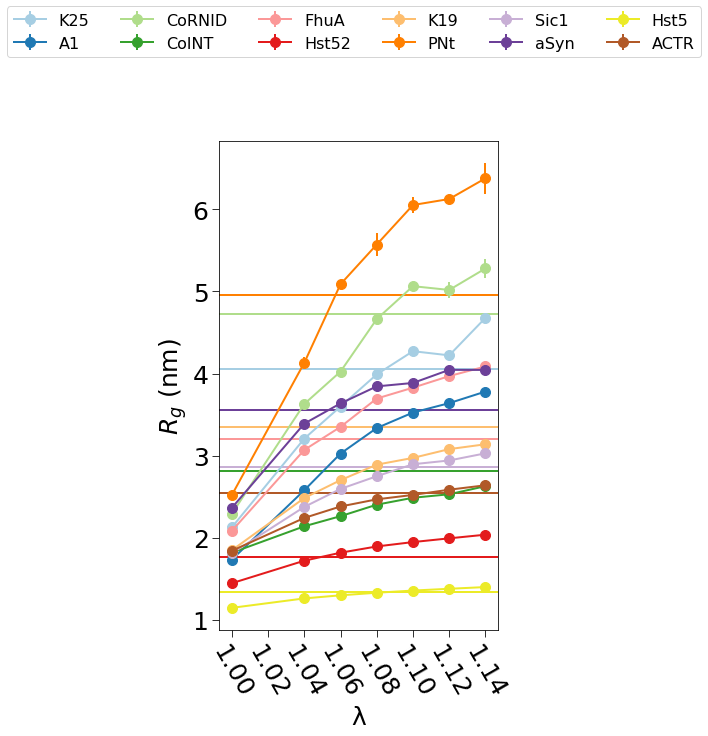

In [4]:
#Start plot
fig = plt.figure(figsize=(5,9))    
x_ticks = np.arange(1.00, 1.16, step=0.02)

lambda_mins = []
Rg_chi2_vs_protein = []

#Loop over all proteins
for i,protein in enumerate(proteins):
    
    Rg_vs_lambda = []
    Rgerr_vs_lambda = []
    
    #Loop over all PW rescaling lambdas
    for l in lambdas:
        
        #Get Rg
        time, Rg = np.genfromtxt('%s/lambda_%s/Rg_gyrate.xvg' % (str(protein), str(l)), usecols=(0,1), skip_header=27, unpack=True)
        
        #Calc average Rg
        Rg_avg = np.average(Rg)
        Rg_vs_lambda.append(Rg_avg)
        
        #Block error analysis
        blocks_stat = block.blocking(Rg)
        if errmethod != 'knee_loc':
            corr_len, err = block.optimal_block(len(Rg),blocks_stat,method=errmethod)
        elif errmethod == 'knee_loc':
            corr_len, err = block.optimal_block(len(Rg),blocks_stat,method="knee_loc",S=2.7)          
        Rgerr_vs_lambda.append(err)
    
    #Calculate chi2
    Rg_vs_lambda = np.array(Rg_vs_lambda)
    Rg_chi2 = np.square((Rg_vs_lambda-exp_Rg[protein][0])/exp_Rg[protein][1])
    Rg_chi2_vs_protein.append(Rg_chi2)
    
    #Find optimal lambda
    lambda_mins.append(lambdas_float[np.argmin(Rg_chi2)])
    
    #Plot Rg vs lambda
    plt.errorbar(lambdas_float, Rg_vs_lambda, yerr=Rgerr_vs_lambda, fmt='-o', linewidth=2, markersize=10, color=colors[i], label=protein)
    plt.axhline(exp_Rg[protein][0], linewidth=2, color=colors[i])

#Plot settings
fig.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=6)
plt.xticks(x_ticks)
plt.xlabel('λ', fontsize=25)
plt.ylabel('$\it{R}$$_g$ (nm)', fontsize=25)
plt.tick_params(colors='black', direction='out', length=7, labelsize=25)
plt.tick_params(axis='x', colors='black', direction='out', length=7, labelsize=25, rotation=-60)

#Save figures
fig.savefig("figures/Rg_vs_lambda_oneplot.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/Rg_vs_lambda_oneplot.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# Plot chi2 (Rg) vs lambda

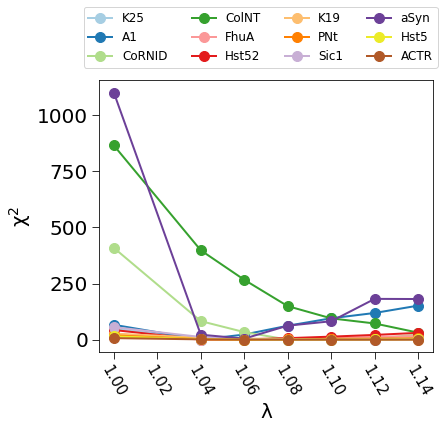

In [5]:
#Start plot
fig = plt.figure(figsize=(6,5))    
plt.xlabel('λ', fontsize=20)
plt.ylabel('χ$^{2}$', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)
plt.tick_params(axis='x', colors='black', direction='out', length=7, labelsize=15, rotation=-60)
plt.xticks(x_ticks)

#Plot
for i,protein in enumerate(proteins):
    plt.plot(lambdas_float, Rg_chi2_vs_protein[i], '-o', linewidth=2, markersize=10, color=colors[i], label=protein)

#Legend
fig.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=4)

#Save figure
fig.savefig("figures/RgChi2_vs_lambda_oneplot.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/RgChi2_vs_lambda_oneplot.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# Load and plot chi2 from SAXS analysis

In [6]:
## Chi2 to SAXS

#Load chi2 pickle
with open('martini3saxs.pkl', "rb") as f:
    SAXSchi2_vs_proteins = pickle.load(f)
SAXSchi2_vs_proteins=SAXSchi2_vs_proteins.drop(columns=['TIA1', 'hSUMO_hnRNPA1','hnRNPA1'])

1.00    20.270116
1.04     5.619301
1.06     3.287536
1.08     1.751664
1.10     1.304300
1.12     0.810126
1.14     0.723711
dtype: float64
1.00    52.559109
1.04    12.406123
1.06     6.836456
1.08     4.064512
1.10     3.693203
1.12     3.766015
1.14     3.703795
dtype: float64


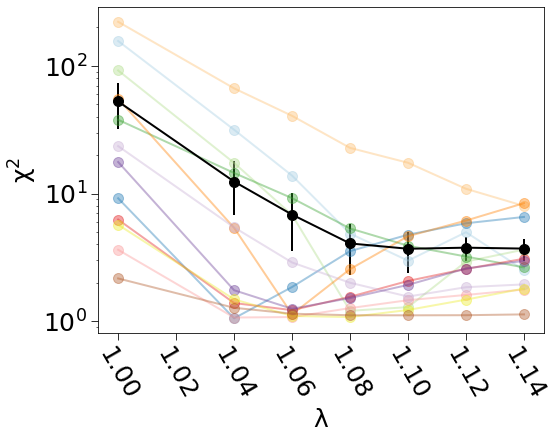

In [7]:
#Set x-ticks
x_ticks = np.arange(1.00, 1.16, step=0.02)

#Get average chi2 over all proteins and SEM
SAXSchi2_average = SAXSchi2_vs_proteins.mean(axis=1)
SAXSchi2_err = SAXSchi2_vs_proteins.sem(axis=1)

#Print chi2 and err
print(SAXSchi2_err)
print(SAXSchi2_average)

#Start plot
fig = plt.figure(figsize=(8,6))
plt.xlabel('λ', fontsize=25)
plt.ylabel('χ$^{2}$', fontsize=25)
plt.tick_params(colors='black', direction='out', length=7, labelsize=25)
plt.tick_params(axis='x', colors='black', direction='out', length=7, labelsize=25, rotation=-60)
plt.xticks(x_ticks)
plt.yscale('log')

#Loop through proteins and plot
for i,protein in enumerate(proteins):
    plt.plot(lambdas_float, SAXSchi2_vs_proteins[protein], '-o', linewidth=2, markersize=10, color=colors[i], alpha=0.4, label=protein)

#Plot average chi2 with error
plt.errorbar(lambdas_float, SAXSchi2_average, yerr=SAXSchi2_err, fmt='-o', linewidth=2, markersize=10, color='black')

#Save figure
fig.savefig("figures/SAXS_Chi2_vs_lambda_oneplot.png", bbox_inches='tight', pad_inches=1, dpi=300)
fig.savefig("figures/SAXS_Chi2_vs_lambda_oneplot.pdf", bbox_inches='tight', pad_inches=1, dpi=300)

# Calculate and plot correlation between compactness and optimal lambda

In [8]:
#Get optimal lambda for each protein based on chi2 to SAXS
lambda_mins_chi2 = []
for i,protein in enumerate(proteins):
    lambda_mins_chi2.append(lambdas_float[np.argmin(SAXSchi2_vs_proteins[protein])])

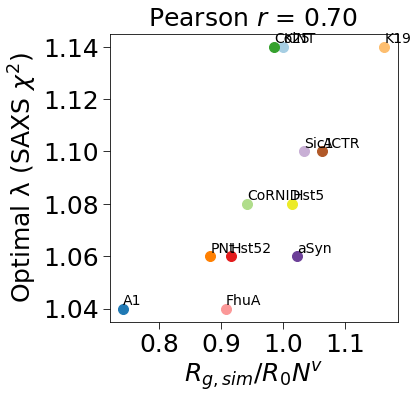

In [9]:
#Analysis with optimal lambda based on chi2 to SAXS

#Start plot
fig= plt.figure(figsize=(4,4))
axes= fig.add_axes([1,1,1,1])
plt.xlabel('$\it{R}$$_{g, sim}$/$\it{R}$$_{0}$$\it{N}$$^{v}$', fontsize=25)
plt.ylabel('Optimal λ (SAXS $\chi^2$)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25) 
plt.tick_params(colors='black', direction='out', length=7)

#Loop through proteins, normalize Rg for sequence length and plot
Rg_lengthnorm_vs_protein = []
for i,protein in enumerate(proteins):
    
    #Normalize Rg to sequence length by Rg power-law
    Rg_lengthnorm = exp_Rg[protein][0]/(0.23*nr_residues[protein]**0.55)
    Rg_lengthnorm_vs_protein.append(Rg_lengthnorm)

    #Plot data point
    plt.plot(Rg_lengthnorm, lambda_mins_chi2[i], 'o', color=colors[i], markersize=10, label=str(protein))
    plt.text(Rg_lengthnorm+0.0004, lambda_mins_chi2[i]+0.003, str(protein), fontsize=14, horizontalalignment='left', verticalalignment='center')

#Get pearson correlation
pearson, pval_pearson = stats.pearsonr(Rg_lengthnorm_vs_protein,lambda_mins_chi2)
plt.text(0.95, 1.148, 'Pearson $\it{r}$ = %2.2f' % (pearson), ha='center', fontsize=25)

#Save figure
fig.savefig("figures/Rg_lengthnorm_vs_lambdaoptchi2.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/Rg_lengthnorm_vs_lambdaoptchi2.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

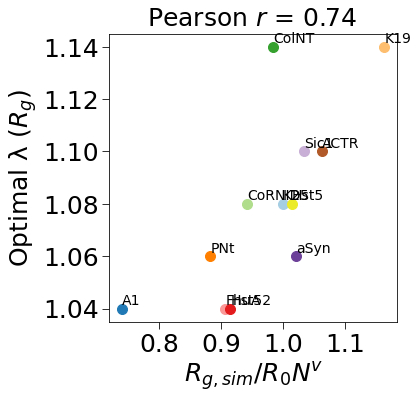

In [10]:
#Analysis with optimal lambda based on deviation from experimental Rg

#Start figure
fig= plt.figure(figsize=(4,4))
axes= fig.add_axes([1,1,1,1])
plt.xlabel('$\it{R}$$_{g, sim}$/$\it{R}$$_{0}$$\it{N}$$^{v}$', fontsize=25)
plt.ylabel('Optimal λ ($R_g$)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25) 
plt.tick_params(colors='black', direction='out', length=7)

#Loop through proteins, normalize Rg for sequence length and plot
Rg_lengthnorm_vs_protein = []
for i,protein in enumerate(proteins):
    
    #Normalize Rg to sequence length by Rg power-law
    Rg_lengthnorm = exp_Rg[protein][0]/(0.23*nr_residues[protein]**0.55)
    Rg_lengthnorm_vs_protein.append(Rg_lengthnorm)
    
    #Plot data point
    plt.plot(Rg_lengthnorm, lambda_mins[i], 'o', color=colors[i], markersize=10, label=str(protein))
    plt.text(Rg_lengthnorm+0.0004, lambda_mins[i]+0.003, str(protein), fontsize=14, horizontalalignment='left', verticalalignment='center')

#Get pearson correlation
pearson, pval_pearson = stats.pearsonr(Rg_lengthnorm_vs_protein,lambda_mins)
plt.text(0.95, 1.148, 'Pearson $\it{r}$ = %2.2f' % (pearson), ha='center', fontsize=25)

#Save figure
fig.savefig("figures/Rg_lengthnorm_vs_lambdaopt.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/Rg_lengthnorm_vs_lambdaopt.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# Plot Rg distributions

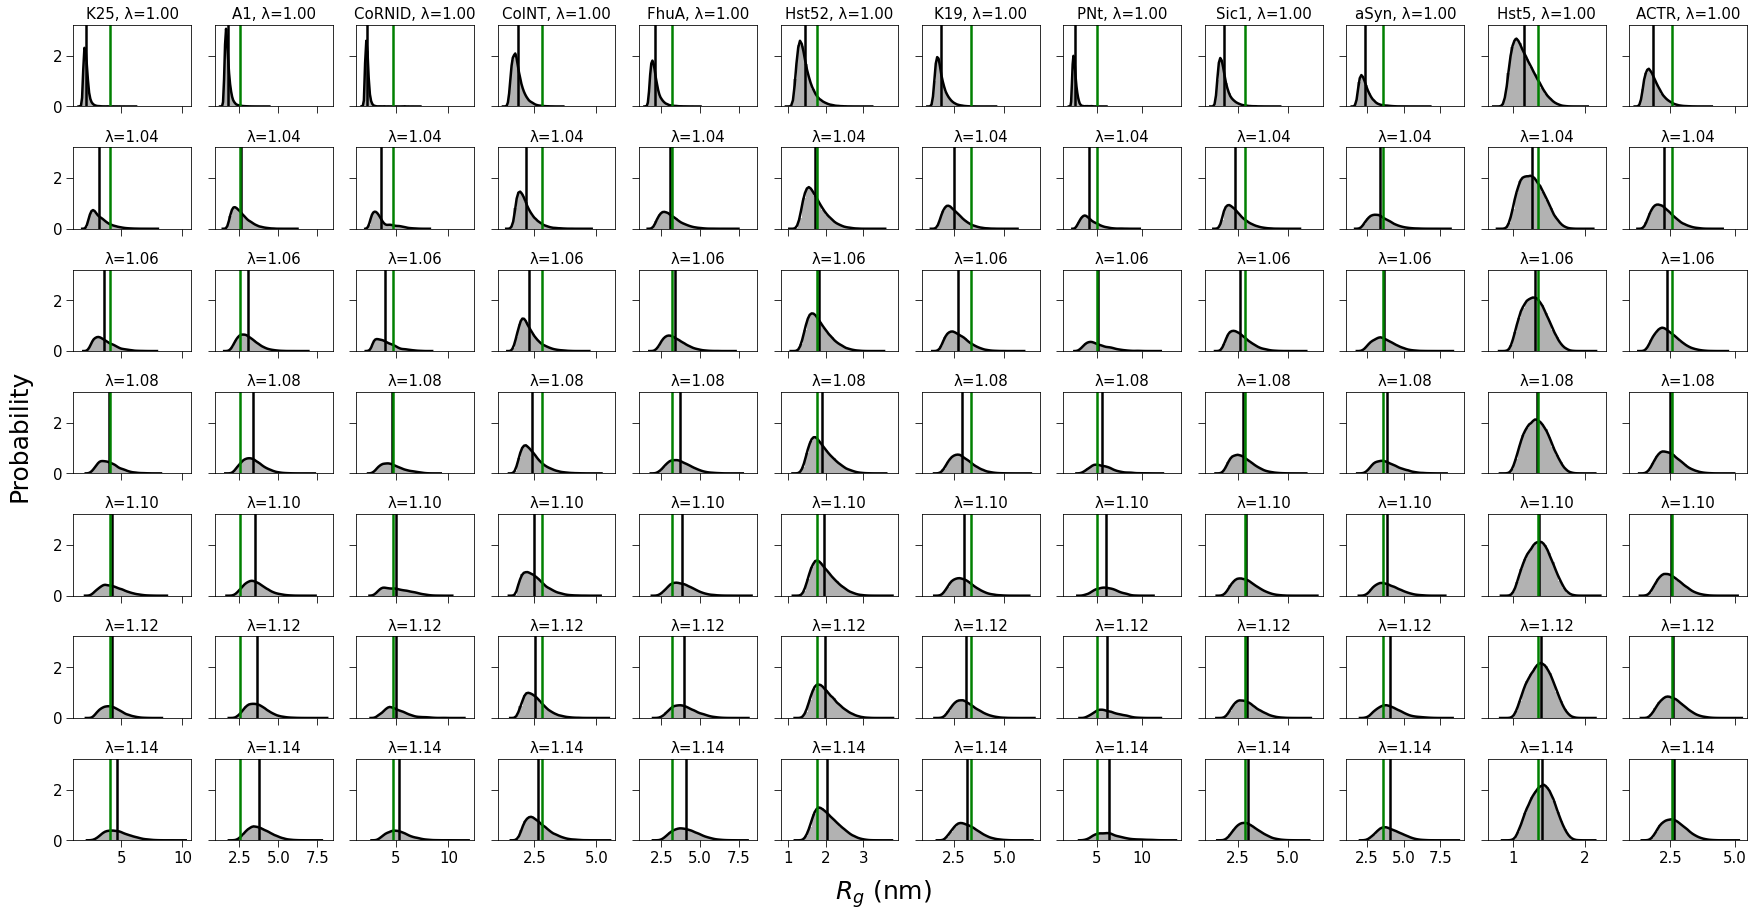

In [11]:
#Start plot
fig, ax = plt.subplots(figsize=(30,15), nrows=len(lambdas), ncols=len(proteins), sharey='all', sharex='col')    
plt.subplots_adjust(hspace = 0.50)
fig.text(0.5, 0.09, '$\it{R}$$_g$ (nm)', ha='center', va='top', fontsize=25)
fig.text(0.1, 0.5, 'Probability', ha='center', va='center', fontsize=25, rotation=90)

n = 0
#Loop over all proteins
for protein in proteins:
    k=0
    
    #Loop over all PW rescaling lambdas
    for l in lambdas:
        
        #Get Rg
        time, Rg = np.genfromtxt('%s/lambda_%s/Rg_gyrate.xvg' % (str(protein), str(l)), usecols=(0,1), skip_header=27, unpack=True)
        
        #Do KDE
        kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 50 )
        kde_y = stats.gaussian_kde(Rg, bw_method = "silverman").evaluate(kde_x)
        
        #Plot histogram and KDE
        ax[k,n].hist(Rg, density=True, color='black', alpha=0.3, bins=20)
        ax[k,n].plot(kde_x, kde_y, '-', linewidth=2.5, color='black')
        ax[k,n].tick_params(colors='black', direction='out', length=7, labelsize=15)
        
        #Plot average and experimental
        ax[k,n].axvline(np.average(Rg),linewidth=2.5, alpha=1, color='black', label='Simulation average')
        ax[k,n].axvline(exp_Rg[protein][0],linewidth=2.5, alpha=1, color='green', label='Experimental')
        
        #Set title for top row
        if k == 0:
            ax[k,n].set_title('%s, λ=%s' % (str(protein), str(l)), fontsize=15)
        #Set title for other rows
        else:
            ax[k,n].set_title('λ=%s' % str(l), fontsize=15)
        
        k+=1
    n+=1

#Save figure
fig.savefig("figures/Rg_distributions.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/Rg_distributions.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# Experimental Rg - simulation Rg correlations and plots

In [12]:
#Make lists for Rgs and errors
expRg_vs_protein_vs_lambda = []
expRgerr_vs_protein_vs_lambda = []
simRg_vs_protein_vs_lambda = []
simRgerr_vs_protein_vs_lambda = []

#Loop over lambdas
for i,l in enumerate(lambdas):
    expRg_vs_protein_vs_lambda.append([])
    expRgerr_vs_protein_vs_lambda.append([])
    simRg_vs_protein_vs_lambda.append([])
    simRgerr_vs_protein_vs_lambda.append([])

    #Loop over proteins
    for j,protein in enumerate(proteins):
        
        #Get Rg and average
        time, Rg = np.genfromtxt('%s/lambda_%s/Rg_gyrate.xvg' % (str(protein), str(l)), usecols=(0,1), skip_header=27, unpack=True)
        Rg_sim = (np.average(Rg))
        
        #Block error analysis
        blocks_stat = block.blocking(Rg)
        if errmethod != 'knee_loc':
            corr_len, err = block.optimal_block(len(Rg),blocks_stat,method=errmethod)
        elif errmethod == 'knee_loc':
            corr_len, err = block.optimal_block(len(Rg),blocks_stat,method="knee_loc",S=2.7)
             
        #Append Rgs and errors to array
        expRg_vs_protein_vs_lambda[i].append(exp_Rg[proteins[j]][0])
        expRgerr_vs_protein_vs_lambda[i].append(exp_Rg[proteins[j]][1])
        simRg_vs_protein_vs_lambda[i].append(Rg_sim)
        simRgerr_vs_protein_vs_lambda[i].append(err)  

/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


In [13]:
#Linear regression of Rgsim vs Rgexp (with intercept 0)
#With error weighting in linear regression

#Convert lists to numpy arrays
expRg_vs_protein_vs_lambda = np.array(expRg_vs_protein_vs_lambda)
expRgerr_vs_protein_vs_lambda = np.array(expRgerr_vs_protein_vs_lambda)
simRg_vs_protein_vs_lambda = np.array(simRg_vs_protein_vs_lambda)
simRgerr_vs_protein_vs_lambda = np.array(simRgerr_vs_protein_vs_lambda)

slope_vs_lambda_errweighting = []
pearson_vs_lambda = []

#Loop over lambdas
for i in range(len(lambdas)):
    
    #Error weighting (1/err^2)
    sample_weight=1.0/(expRgerr_vs_protein_vs_lambda[i]**2)
    
    #Linear regression (lambda_sim vs lambda_exp)
    reg = LinearRegression(fit_intercept=False).fit(expRg_vs_protein_vs_lambda[i].reshape(-1,1),simRg_vs_protein_vs_lambda[i].reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(expRg_vs_protein_vs_lambda[i].reshape(-1,1),simRg_vs_protein_vs_lambda[i].reshape(-1,1),sample_weight=sample_weight)
    slope = reg.coef_[0]
    slope_vs_lambda_errweighting.append(slope)
    
    #Get pearson correlation (lambda_sim vs lambda_exp)
    pearson, pval_pearson = stats.pearsonr(expRg_vs_protein_vs_lambda[i],simRg_vs_protein_vs_lambda[i])    
    pearson_vs_lambda.append(pearson)


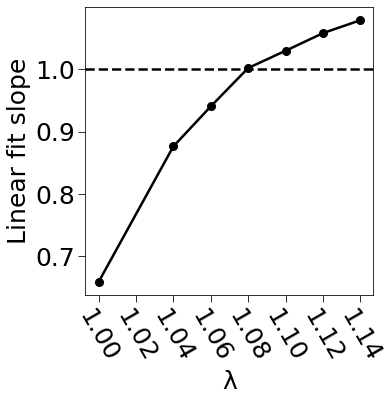

In [14]:
#Plot linear fit slope as a function of lambda

#Start plot
fig= plt.figure(figsize=(4,4))
axes= fig.add_axes([1,1,1,1])

#Plot slope and horizontal line at slope=1
plt.plot(lambdas_float, slope_vs_lambda_errweighting, '-o', color='black', linewidth=2.5, markersize=8, label='Error weighting in regression')
plt.axhline(1.0, linestyle="--", linewidth=2.5, color='black')

#Plot stuff
plt.xlabel('λ', fontsize=25)
plt.ylabel('Linear fit slope', fontsize=25)
plt.xticks(np.arange(1.00, 1.16, step=0.02), fontsize=25)
plt.yticks(fontsize=25) 
plt.tick_params(colors='black', direction='out', length=7)
plt.tick_params(axis='x', colors='black', direction='out', length=7, labelsize=25, rotation=-60)

#Save figure
fig.savefig("figures/RgsimRgexp_linearfitslope_vs_lambda.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/RgsimRgexp_linearfitslope_vs_lambda.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

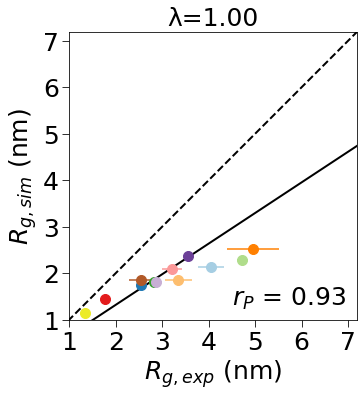

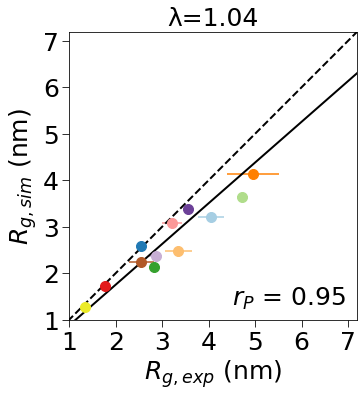

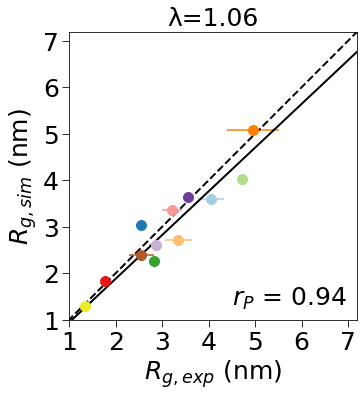

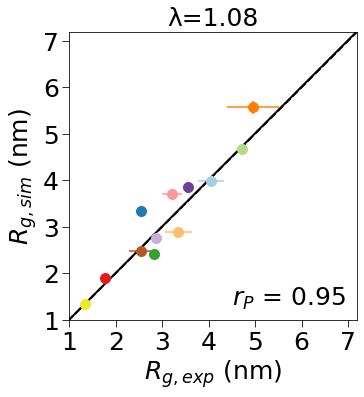

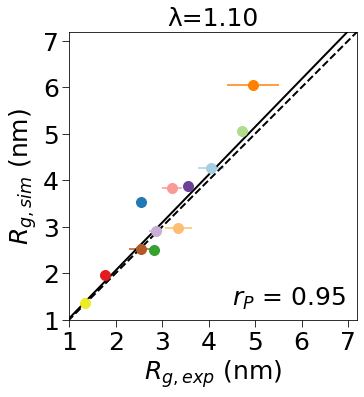

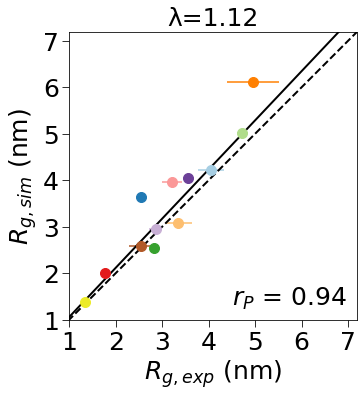

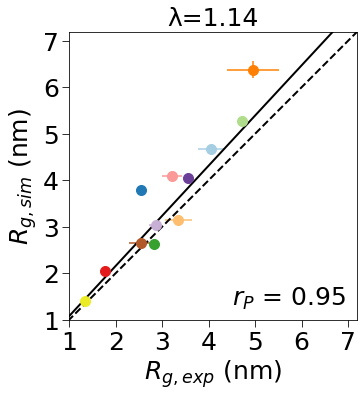

In [15]:
#Plot Rgsim vs Rgexp with linear fits

#Loop over lambdas to make plot for each lambda
for i in range(len(lambdas)):
    
    #Start plot
    fig= plt.figure(figsize=(4,4))
    axes= fig.add_axes([1,1,1,1])
    
    #plot stuff
    plt.title('λ=' + str(lambdas[i]), fontsize=25)
    plt.xlabel('$\it{R}$$_{g, exp}$ (nm)', fontsize=25)
    plt.ylabel('$\it{R}$$_{g, sim}$ (nm)', fontsize=25)
    plt.xlim(1.0,7.2)
    plt.ylim(1.0,7.2)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25) 
    plt.tick_params(colors='black', direction='out', length=7)
    
    #Plot diagonal
    x=[0,100]
    y=[0,100]
    plt.plot(x,y,'--',linewidth=2,color='black')
    
    #Plot linear fits to data
    plt.plot([1,100],[slope_vs_lambda_errweighting[i],slope_vs_lambda_errweighting[i]*100],linewidth=2,color='black', label='Error weighting in regression')
    
    #Write pearson correlation
    plt.text(4.5, 1.3, '$r_P$ = %2.2f' % pearson_vs_lambda[i], fontsize=25)
    
    #Loop over proteins and plot Rg_sim vs Rg_exp data points
    for j in range(len(proteins)):
        plt.errorbar(expRg_vs_protein_vs_lambda[i][j], simRg_vs_protein_vs_lambda[i][j], xerr=expRgerr_vs_protein_vs_lambda[i][j], yerr=simRgerr_vs_protein_vs_lambda[i][j], fmt='o', color=colors[j], markersize=10)
        #plt.text(expRg_vs_protein_vs_lambda[i][j]+0.1, simRg_vs_protein_vs_lambda[i][j]+0.12, str(proteins[j]), fontsize=14, horizontalalignment='left', verticalalignment='center')
    
    #Save figure
    fig.savefig("figures/Rgsim_vs_Rgexp_linearfits_lambda%s.png" % lambdas[i], bbox_inches='tight', pad_inches=1, dpi=400)
    fig.savefig("figures/Rgsim_vs_Rgexp_linearfits_lambda%s.pdf" % lambdas[i], bbox_inches='tight', pad_inches=1, dpi=400)

# Sequence length normalized Rg analysis

## Scaling exponent based on experimental Rg

In [16]:
#Make list of expRg expRg_err and nr residues
expRg_vs_protein = []
expRg_err_vs_protein = []
nr_residues_vs_protein = []

#Loop over proteins and append to lists
for i,protein in enumerate(proteins):
    expRg_vs_protein.append(exp_Rg[protein][0])
    expRg_err_vs_protein.append(exp_Rg[protein][1])
    nr_residues_vs_protein.append(nr_residues[protein])

#Make numpy arrays
expRg_vs_protein = np.array(expRg_vs_protein)
nr_residues_vs_protein = np.array(nr_residues_vs_protein)

In [17]:
#Define function: Rg vs sequence length power law
def Rg_length_scaling(N, R0, v):
    return R0*(N**v)

In [18]:
#Fit Rg vs length power law to experimental Rgs
popt, pcov = curve_fit(Rg_length_scaling, nr_residues_vs_protein, expRg_vs_protein, sigma=expRg_err_vs_protein)
print(popt)
R0_exp = popt[0]
scaling_exponent_exp = popt[1]

[0.22732163 0.5484002 ]


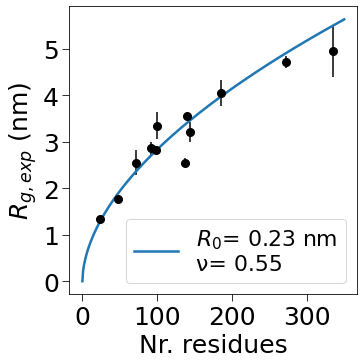

In [19]:
#Plot Rg power law fit

#Start plot
fig= plt.figure(figsize=(4,4))
axes= fig.add_axes([1,1,1,1])

#Plot fit
plt.plot(np.arange(0,350), Rg_length_scaling(np.arange(0,350), *popt), '-', linewidth=2.5, label='$\it{R}$$_{0}$=%5.2f nm\nν=%5.2f' % tuple(popt), markersize=8)
#Plot experimental Rg vs length
plt.errorbar(nr_residues_vs_protein, expRg_vs_protein, yerr=expRg_err_vs_protein, fmt='o', color='black', markersize=8)

#Plot stuff
plt.xlabel('Nr. residues', fontsize=25)
plt.ylabel('$\it{R}$$_{g, exp}$ (nm)', fontsize=25)
plt.xticks(np.arange(0,400,step=100), fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(colors='black', direction='out', length=7)
plt.legend(fontsize=22)

#Save figure
fig.savefig("figures/scalingexponent_fit_Rgexp.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/scalingexponent_fit_Rgexp.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# Experimental Rg - simulation Rg normalized for sequence length correlations and plots

In [20]:
#Make lists for Rgs and errors
simRgscaled_vs_protein_vs_lambda = []
simRgscaled_err_vs_protein_vs_lambda = []
expRgscaled_vs_protein_vs_lambda = []
expRgscaled_err_vs_protein_vs_lambda = []

#Loop over lambdas
for i in range(len(lambdas)): 
    simRgscaled_vs_protein_vs_lambda.append([])
    simRgscaled_err_vs_protein_vs_lambda.append([])
    expRgscaled_vs_protein_vs_lambda.append([])
    expRgscaled_err_vs_protein_vs_lambda.append([])
    
    #Loop over proteins
    for j in range(len(proteins)):
        
        #Normalize Rg for sequence-length with Rg power law fitted above and append to lists
        Rg_scaling = Rg_length_scaling(nr_residues[proteins[j]], R0_exp, scaling_exponent_exp)
        simRgscaled_vs_protein_vs_lambda[i].append(simRg_vs_protein_vs_lambda[i][j]/Rg_scaling)
        simRgscaled_err_vs_protein_vs_lambda[i].append(simRgerr_vs_protein_vs_lambda[i][j]/Rg_scaling)
        expRgscaled_vs_protein_vs_lambda[i].append(expRg_vs_protein_vs_lambda[i][j]/Rg_scaling)
        expRgscaled_err_vs_protein_vs_lambda[i].append(expRgerr_vs_protein_vs_lambda[i][j]/Rg_scaling)

#Make lists numpy arrays
simRgscaled_vs_protein_vs_lambda = np.array(simRgscaled_vs_protein_vs_lambda)
simRgscaled_err_vs_protein_vs_lambda = np.array(simRgscaled_err_vs_protein_vs_lambda)
expRgscaled_vs_protein_vs_lambda = np.array(expRgscaled_vs_protein_vs_lambda)
expRgscaled_err_vs_protein_vs_lambda = np.array(expRgscaled_err_vs_protein_vs_lambda)

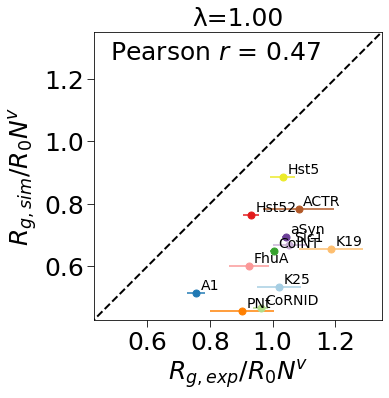

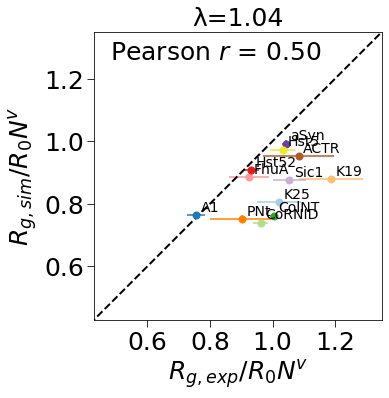

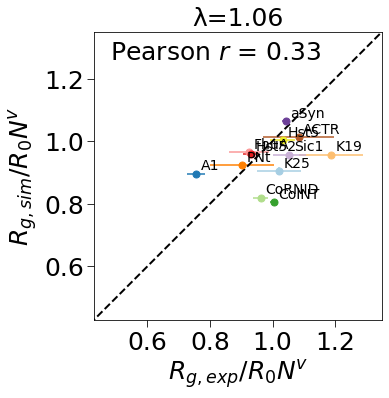

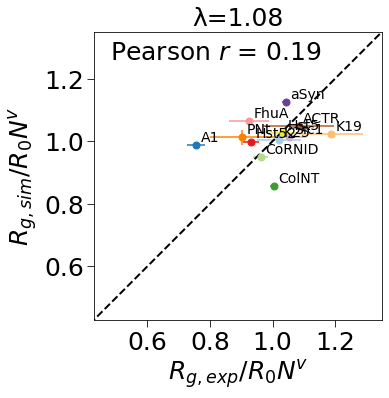

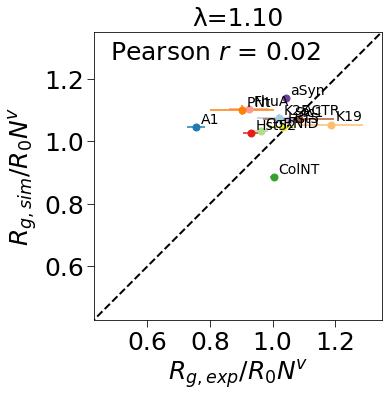

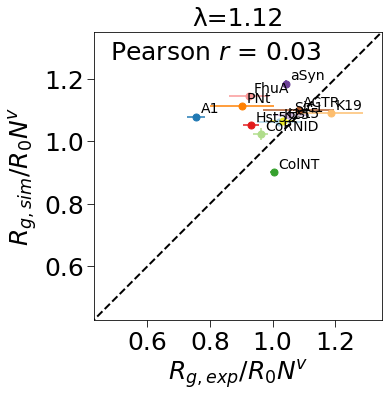

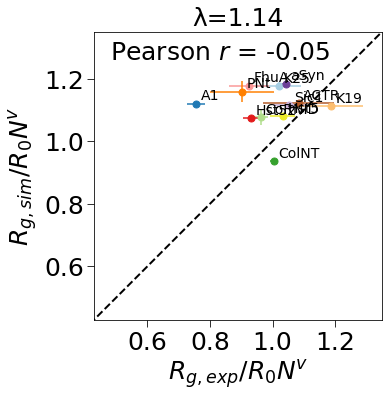

In [21]:
#Get correlations and plot

#Loop over lambdas and make plot for each lambda
pearson_vs_lambda = []
for i in range(len(lambdas)):    
    
    #Get pearson correlation
    pearson, pval_pearson = stats.pearsonr(expRgscaled_vs_protein_vs_lambda[i],simRgscaled_vs_protein_vs_lambda[i])
    pearson_vs_lambda.append(pearson)
    
    #Start plot
    fig= plt.figure(figsize=(4,4))
    axes= fig.add_axes([1,1,1,1])
    
    #Plot stuff
    plt.title('λ=' + str(lambdas[i]), fontsize=25)
    plt.xlabel('$\it{R}$$_{g, exp}$/$\it{R}$$_{0}$$\it{N}$$^{v}$', fontsize=25)
    plt.ylabel('$\it{R}$$_{g, sim}$/$\it{R}$$_{0}$$\it{N}$$^{v}$', fontsize=25)
    plt.text(0.48, 1.26, 'Pearson $\it{r}$ = %2.2f' % (pearson), fontsize=25)
    plt.xlim(0.43,1.35)
    plt.ylim(0.43,1.35)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25) 
    plt.tick_params(colors='black', direction='out', length=7)
    
    #Plot diagonal
    x=[0,100]
    y=[0,100]
    plt.plot(x,y,'--',linewidth=2,color='black')
    
    #Loop over proteins and plot Rg_sim vs Rg_exp (length-normalized) data points
    for j in range(len(proteins)):
        plt.errorbar(expRgscaled_vs_protein_vs_lambda[i][j], simRgscaled_vs_protein_vs_lambda[i][j], xerr=expRgscaled_err_vs_protein_vs_lambda[i][j], yerr=simRgscaled_err_vs_protein_vs_lambda[i][j], fmt='o', color=colors[j], markersize=7, label=str(proteins[j]))
        plt.text(expRgscaled_vs_protein_vs_lambda[i][j]+0.015, simRgscaled_vs_protein_vs_lambda[i][j]+0.025, str(proteins[j]), fontsize=14, horizontalalignment='left', verticalalignment='center')
    
    #Save figure
    fig.savefig("figures/Rgsim_vs_Rgexp_lengthnormalized_lambda%s.png" % lambdas[i], bbox_inches='tight', pad_inches=1, dpi=400)
    fig.savefig("figures/Rgsim_vs_Rgexp_lengthnormalized_lambda%s.pdf" % lambdas[i], bbox_inches='tight', pad_inches=1, dpi=400)


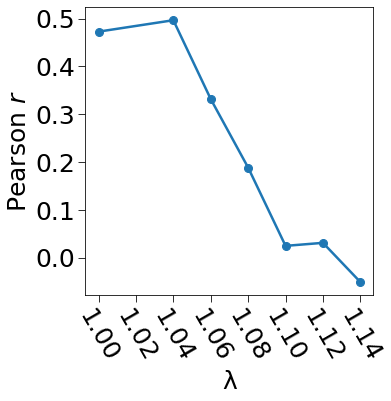

In [22]:
#Plot pearson r vs lambda

#Start plot
fig= plt.figure(figsize=(4,4))
axes= fig.add_axes([1,1,1,1])

#plot
plt.plot(lambdas_float, pearson_vs_lambda, '-o', linewidth=2.5, markersize=8, label = 'Pearson $\it{r}$')

#Plot stuff
plt.xlabel('λ', fontsize=25)
plt.ylabel('Pearson $r$', fontsize=25)
plt.xticks(np.arange(1.00, 1.16, step=0.02), fontsize=25)
plt.yticks(fontsize=25) 
plt.tick_params(colors='black', direction='out', length=7)
plt.tick_params(axis='x', colors='black', direction='out', length=7, labelsize=25, rotation=-60)

#Save figure
fig.savefig("figures/Rgsim_Rgexp_lengthnormalized_correlation_vs_lambda.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/Rgsim_Rgexp_lengthnormalized_correlation_vs_lambda.pdf", bbox_inches='tight', pad_inches=1, dpi=400)


# Select Tau K25 frames for figure 1a

In [3]:
#Find frame of Tau K25 with average Rg for each lambda (1.00, 1.06, 1.08)

#Loop over lambdas
for l in ['1.00','1.06','1.08']:
    
    #Get Rg
    time, Rg = np.genfromtxt(f'K25/lambda_{l}/Rg_gyrate.xvg', usecols=(0,1), skip_header=27, unpack=True)

    #Find average Rg
    average_Rg = np.average(Rg)
    
    #Get square error between each Rg in time-series and average Rg
    MSE_Rg = np.square(Rg-average_Rg)
    
    #Get index of frame with Rg closest to average
    frame_index = np.argmin(MSE_Rg)
    
    #Load traj
    traj = md.load(f'K25/lambda_{l}/prodrun_nopbc.xtc', top=f'K25/PRO_CG.gro')
    
    #Select frame
    frame = traj[frame_index]
    
    #Save pdb of frame
    frame.save_pdb(f'K25/K25_frame_averageRg_lambda{l}.pdb')

# Check distance to periodic image

WARNING! A1 with lambda 1.12 comes within 0.833000 nm of its periodic image.
WARNING! A1 with lambda 1.14 comes within 1.090000 nm of its periodic image.
WARNING! PNt with lambda 1.12 comes within 0.947000 nm of its periodic image.
WARNING! PNt with lambda 1.14 comes within 0.347000 nm of its periodic image.


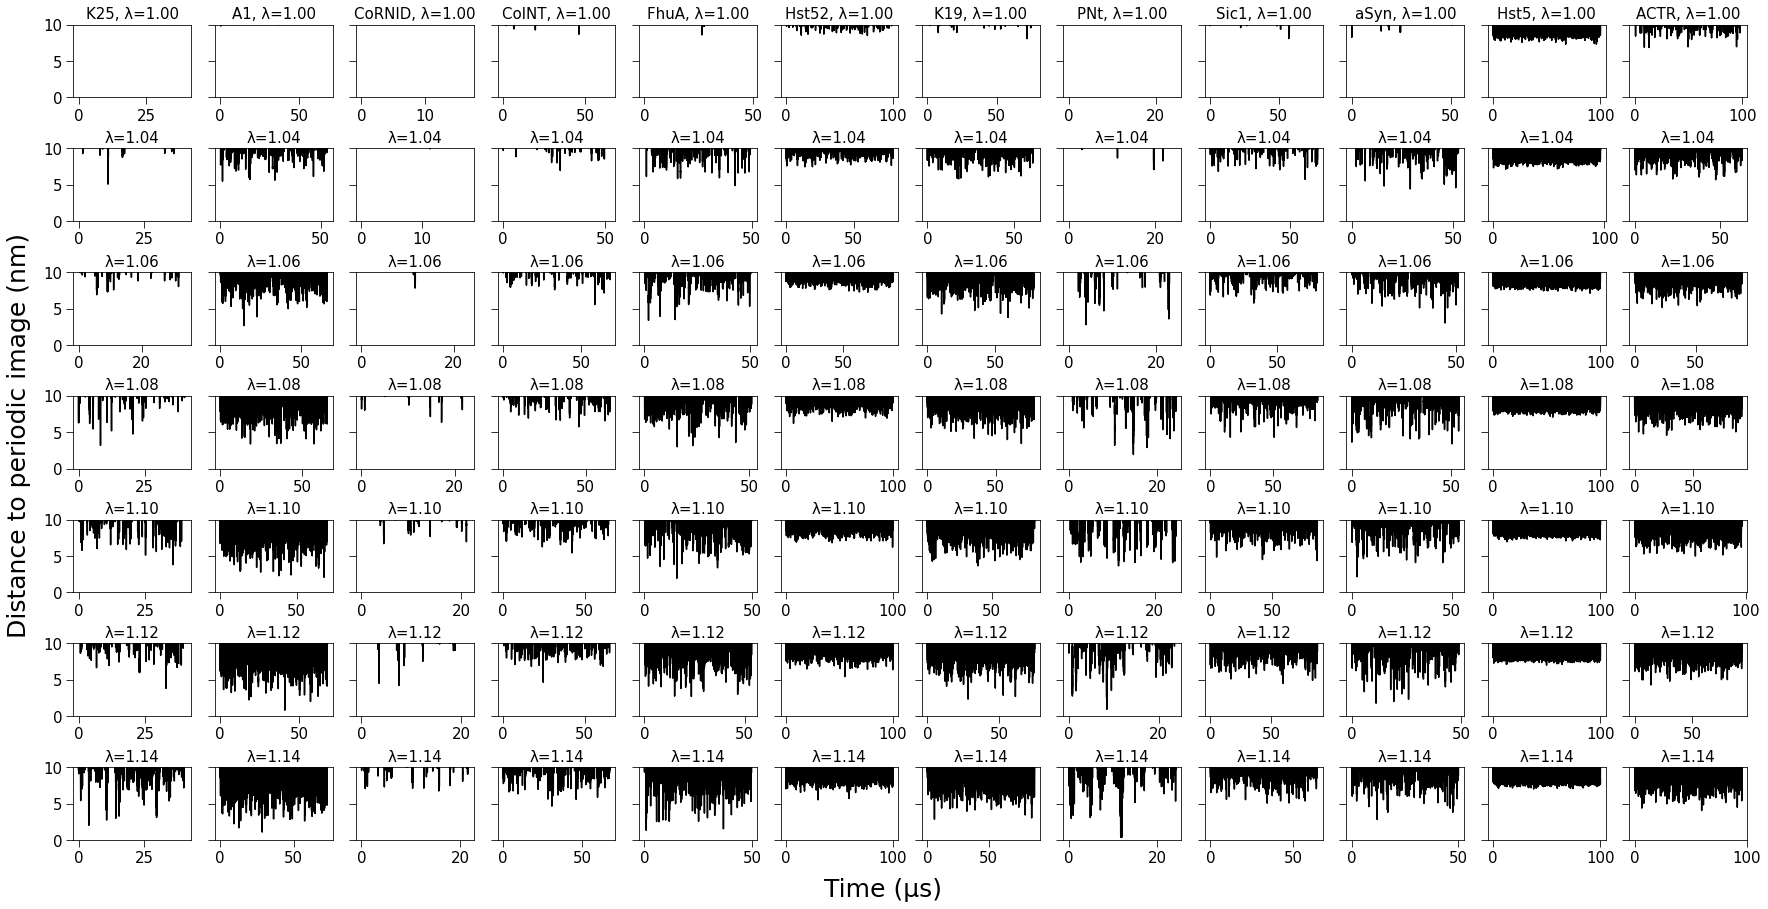

In [24]:
#Make outfile to log proteins that come too close to PI
PI_warning_outfile='PI_distance_warnings.log'
with open(PI_warning_outfile,'w') as f:
    f.write("# Simulations with distance to PI below the cut-off \n# Protein \tLambda \tShortest_dist_PI (nm) \n")

#Start plot
fig, ax = plt.subplots(figsize=(30,15), nrows=len(lambdas), ncols=len(proteins), sharey='all')    
plt.subplots_adjust(hspace = 0.70)
fig.text(0.5, 0.09, 'Time (µs)', ha='center', va='top', fontsize=25)
fig.text(0.1, 0.5, 'Distance to periodic image (nm)', ha='center', va='center', fontsize=25, rotation=90)

n = 0
#Loop over all proteins
for protein in proteins:
    k=0
    #Loop over all PW rescaling lambdas
    for l in lambdas:
        
        #Get distance to PI over time
        time, distance = np.genfromtxt('%s/lambda_%s/pi_mindist.xvg' % (str(protein), str(l)), usecols=(0,1), skip_header=29, unpack=True)
            
        #Find shortest distance and check if it is below the acceptable distance
        minimum_distance = np.amin(distance)
        if minimum_distance <= PI_distance_cutoff:
            print("WARNING! %s with lambda %s comes within %f nm of its periodic image." % (str(protein), str(l), minimum_distance))
            #Write to outfile
            with open(PI_warning_outfile, 'a') as f:
                f.write("%s \t%s \t%f \n" % (str(protein), str(l), minimum_distance))
                
        #Plot distance to PI vs time
        ax[k,n].plot(time, distance, '-', color='black')
        
        #Set title for top row
        if k == 0:
            ax[k,n].set_title('%s, λ=%s' % (str(protein), str(l)), fontsize=15)
        #Set title for other rows
        else:
            ax[k,n].set_title('λ=%s' % str(l), fontsize=15)
        
        #Plot stuff
        ax[k,n].set_ylim(0,10)
        ax[k,n].tick_params(colors='black', direction='out', length=7, labelsize=15)
        
        k+=1
    n+=1

#Save figure
fig.savefig("figures/PI_distances.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/PI_distances.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

# Get box dimensions and number of atoms


In [25]:
for protein in proteins:
    
    #Read EM gro-file
    with open(f'{protein}/min.gro', 'r') as f:
        lines = f.readlines()
    
    #Get box d
    box_line = lines[len(lines)-1].split()
    box_d = box_line[0]
    print(f'{protein}: d = {box_d} nm')
    
for protein in PRE_proteins:
    
    #Read EM gro-file
    with open(f'{protein}/min.gro', 'r') as f:
        lines = f.readlines()
    
    #Get box d
    box_line = lines[len(lines)-1].split()
    box_d = box_line[0]
    print(f'{protein}: d = {box_d} nm')

K25: d = 27.35668 nm
A1: d = 21.52759 nm
CoRNID: d = 32.46644 nm
ColNT: d = 20.52739 nm
FhuA: d = 23.92441 nm
Hst52: d = 17.38765 nm
K19: d = 20.36227 nm
PNt: d = 31.17408 nm
Sic1: d = 21.41046 nm
aSyn: d = 24.10945 nm
Hst5: d = 13.69146 nm
ACTR: d = 18.89683 nm
FUS: d = 19.43544 nm
A2: d = 21.79783 nm


# Check Rg convergence

Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 2

Removing 3 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 12

Removing 4 at the bottom of each replica
Possible blocks transformations: 4

Removing 5 at the bottom of each replica
Possible blocks transformations: 4

Removing 6 at the bottom of each replica
Possible blocks transformations: 8

Removing 7 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 4

Removing 3 at the bottom of each replica
Possible blocks transformations: 12

Removing 4 at the bottom of each replica
Possible blocks transformations: 8

Removing 5 at the bottom of each replica
Possible blocks transformations: 20



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 4

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 4

Removing 5 at the bottom of each replica
Possible blocks transformations: 16

Removing 6 at the bottom of each replica
Possible blocks transformations: 16

Removing 7 at the bottom of each replica
Possible blocks transformations: 4

Removing 8 at the bottom of each replica
Possible blocks transformations: 2

Removing 9 at the bottom of each replica
Possible blocks transformations: 18

Removing 10 at the bottom of each replica
Possible blocks transformations: 4

Removing 11 at the bottom of each replica
Possible blocks transformations: 8

Removing 12 at the bottom of each replica
Possible blocks transformations: 8

Removing 13 at the bottom of each replica
Possible blocks transformat

/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 2

Removing 3 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 2

Removing 2 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 40



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 60
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 24
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 4

Removing 3 at the bottom of each replica
Possible blocks transformations: 48



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 2

Removing 2 at the bottom of each replica
Possible blocks transformations: 48



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 12

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 12

Removing 5 at the bottom of each replica
Possible blocks transformations: 2

Removing 6 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 4

Removing 2 at the bottom of each replica
Possible blocks transformations: 6

Removing 3 at the bottom of each replica
Possible blocks transformations: 6

Removing 4 at the bottom of each replica
Possible blocks transformations: 8

Removing 5 at the bottom of each replica
Possible blocks transformations: 4

Removing 6 at the bottom of each replica
Possible blocks transformations: 72



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 16

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 8

Removing 5 at the bottom of each replica
Possible blocks transformations: 4

Removing 6 at the bottom of each replica
Possible blocks transformations: 12

Removing 7 at the bottom of each replica
Possible blocks transformations: 8

Removing 8 at the bottom of each replica
Possible blocks transformations: 8

Removing 9 at the bottom of each replica
Possible blocks transformations: 2

Removing 10 at the bottom of each replica
Possible blocks transformations: 40



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 4

Removing 4 at the bottom of each replica
Possible blocks transformations: 4

Removing 5 at the bottom of each replica
Possible blocks transformations: 42



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 10

Removing 3 at the bottom of each replica
Possible blocks transformations: 16

Removing 4 at the bottom of each replica
Possible blocks transformations: 12

Removing 5 at the bottom of each replica
Possible blocks transformations: 2

Removing 6 at the bottom of each replica
Possible blocks transformations: 12

Removing 7 at the bottom of each replica
Possible blocks transformations: 4

Removing 8 at the bottom of each replica
Possible blocks transformations: 8

Removing 9 at the bottom of each replica
Possible blocks transformations: 2

Removing 10 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 2

Removing 2 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 4

Removing 3 at the bottom of each replica
Possible blocks transformations: 12

Removing 4 at the bottom of each replica
Possible blocks transformations: 4

Removing 5 at the bottom of each replica
Possible blocks transformations: 48



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 32
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 16

Removing 2 at the bottom of each replica
Possible blocks transformations: 16

Removing 3 at the bottom of each replica
Possible blocks transformations: 2

Removing 4 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 24
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 32
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 12

Removing 4 at the bottom of each replica
Possible blocks transformations: 6

Removing 5 at the bottom of each replica
Possible blocks transformations: 4

Removing 6 at the bottom of each replica
Possible blocks transformations: 4

Removing 7 at the bottom of each replica
Possible blocks transformations: 96



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 6

Removing 2 at the bottom of each replica
Possible blocks transformations: 16

Removing 3 at the bottom of each replica
Possible blocks transformations: 4

Removing 4 at the bottom of each replica
Possible blocks transformations: 8

Removing 5 at the bottom of each replica
Possible blocks transformations: 64



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 4

Removing 4 at the bottom of each replica
Possible blocks transformations: 12

Removing 5 at the bottom of each replica
Possible blocks transformations: 10

Removing 6 at the bottom of each replica
Possible blocks transformations: 8

Removing 7 at the bottom of each replica
Possible blocks transformations: 8

Removing 8 at the bottom of each replica
Possible blocks transformations: 64



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 12

Removing 4 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 4

Removing 2 at the bottom of each replica
Possible blocks transformations: 12

Removing 3 at the bottom of each replica
Possible blocks transformations: 2

Removing 4 at the bottom of each replica
Possible blocks transformations: 20



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 16

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 6

Removing 5 at the bottom of each replica
Possible blocks transformations: 48



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 24
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 32
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 16

Removing 3 at the bottom of each replica
Possible blocks transformations: 20



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 2

Removing 2 at the bottom of each replica
Possible blocks transformations: 12

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 16

Removing 5 at the bottom of each replica
Possible blocks transformations: 16

Removing 6 at the bottom of each replica
Possible blocks transformations: 8

Removing 7 at the bottom of each replica
Possible blocks transformations: 4

Removing 8 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 2

Removing 2 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 40
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 4

Removing 2 at the bottom of each replica
Possible blocks transformations: 12

Removing 3 at the bottom of each replica
Possible blocks transformations: 4

Removing 4 at the bottom of each replica
Possible blocks transformations: 8

Removing 5 at the bottom of each replica
Possible blocks transformations: 12

Removing 6 at the bottom of each replica
Possible blocks transformations: 16

Removing 7 at the bottom of each replica
Possible blocks transformations: 2

Removing 8 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 60



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 32
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 6

Removing 2 at the bottom of each replica
Possible blocks transformations: 16

Removing 3 at the bottom of each replica
Possible blocks transformations: 4

Removing 4 at the bottom of each replica
Possible blocks transformations: 2

Removing 5 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 48
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 6

Removing 2 at the bottom of each replica
Possible blocks transformations: 4

Removing 3 at the bottom of each replica
Possible blocks transformations: 4

Removing 4 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 72



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 2

Removing 2 at the bottom of each replica
Possible blocks transformations: 16

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 2

Removing 2 at the bottom of each replica
Possible blocks transformations: 18

Removing 3 at the bottom of each replica
Possible blocks transformations: 12

Removing 4 at the bottom of each replica
Possible blocks transformations: 16

Removing 5 at the bottom of each replica
Possible blocks transformations: 4

Removing 6 at the bottom of each replica
Possible blocks transformations: 20



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 16

Removing 2 at the bottom of each replica
Possible blocks transformations: 4

Removing 3 at the bottom of each replica
Possible blocks transformations: 4

Removing 4 at the bottom of each replica
Possible blocks transformations: 8

Removing 5 at the bottom of each replica
Possible blocks transformations: 12

Removing 6 at the bottom of each replica
Possible blocks transformations: 4

Removing 7 at the bottom of each replica
Possible blocks transformations: 16

Removing 8 at the bottom of each replica
Possible blocks transformations: 8

Removing 9 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 24
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 12

Removing 3 at the bottom of each replica
Possible blocks transformations: 16

Removing 4 at the bottom of each replica
Possible blocks transformations: 2

Removing 5 at the bottom of each replica
Possible blocks transformations: 16

Removing 6 at the bottom of each replica
Possible blocks transformations: 2

Removing 7 at the bottom of each replica
Possible blocks transformations: 16

Removing 8 at the bottom of each replica
Possible blocks transformations: 8

Removing 9 at the bottom of each replica
Possible blocks transformations: 12

Removing 10 at the bottom of each replica
Possible blocks transformations: 8

Removing 11 at the bottom of each replica
Possible blocks transformations: 12

Removing 12 at the bottom of each replica
Possible blocks transformations: 6

Removing 13 at the bottom of each replica
Possible blocks transfor

/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 4

Removing 2 at the bottom of each replica
Possible blocks transformations: 72



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 10

Removing 2 at the bottom of each replica
Possible blocks transformations: 6

Removing 3 at the bottom of each replica
Possible blocks transformations: 4

Removing 4 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 4

Removing 2 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 16

Removing 2 at the bottom of each replica
Possible blocks transformations: 4

Removing 3 at the bottom of each replica
Possible blocks transformations: 12

Removing 4 at the bottom of each replica
Possible blocks transformations: 8

Removing 5 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 4

Removing 3 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 16

Removing 4 at the bottom of each replica
Possible blocks transformations: 8

Removing 5 at the bottom of each replica
Possible blocks transformations: 64



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 2

Removing 2 at the bottom of each replica
Possible blocks transformations: 16

Removing 3 at the bottom of each replica
Possible blocks transformations: 12

Removing 4 at the bottom of each replica
Possible blocks transformations: 16

Removing 5 at the bottom of each replica
Possible blocks transformations: 2

Removing 6 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 32
 no lenght correction needed



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 4

Removing 2 at the bottom of each replica
Possible blocks transformations: 20



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 6

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 4

Removing 5 at the bottom of each replica
Possible blocks transformations: 16

Removing 6 at the bottom of each replica
Possible blocks transformations: 8

Removing 7 at the bottom of each replica
Possible blocks transformations: 16

Removing 8 at the bottom of each replica
Possible blocks transformations: 8

Removing 9 at the bottom of each replica


/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 24

Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 36



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 12

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 2

Removing 5 at the bottom of each replica
Possible blocks transformations: 40



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 20



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 4

Removing 2 at the bottom of each replica
Possible blocks transformations: 4

Removing 3 at the bottom of each replica
Possible blocks transformations: 32



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 12

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 8

Removing 5 at the bottom of each replica
Possible blocks transformations: 8

Removing 6 at the bottom of each replica
Possible blocks transformations: 10

Removing 7 at the bottom of each replica
Possible blocks transformations: 24



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 16

Removing 2 at the bottom of each replica
Possible blocks transformations: 8

Removing 3 at the bottom of each replica
Possible blocks transformations: 16

Removing 4 at the bottom of each replica
Possible blocks transformations: 12

Removing 5 at the bottom of each replica
Possible blocks transformations: 16

Removing 6 at the bottom of each replica
Possible blocks transformations: 2

Removing 7 at the bottom of each replica
Possible blocks transformations: 12

Removing 8 at the bottom of each replica
Possible blocks transformations: 4

Removing 9 at the bottom of each replica
Possible blocks transformations: 8

Removing 10 at the bottom of each replica
Possible blocks transformations: 16

Removing 11 at the bottom of each replica
Possible blocks transformations: 10

Removing 12 at the bottom of each replica
Possible blocks transformations: 4

Removing 13 at the bottom of each replica
Possible blocks transfor

/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 16

Removing 3 at the bottom of each replica
Possible blocks transformations: 4

Removing 4 at the bottom of each replica
Possible blocks transformations: 16

Removing 5 at the bottom of each replica
Possible blocks transformations: 6

Removing 6 at the bottom of each replica


/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


Possible blocks transformations: 36

Removing 1 at the bottom of each replica
Possible blocks transformations: 8

Removing 2 at the bottom of each replica
Possible blocks transformations: 12

Removing 3 at the bottom of each replica
Possible blocks transformations: 8

Removing 4 at the bottom of each replica
Possible blocks transformations: 4

Removing 5 at the bottom of each replica
Possible blocks transformations: 8

Removing 6 at the bottom of each replica
Possible blocks transformations: 120



/lindorffgrp-isilon/thomasen/MARTINI_PWrescaling/IDP/Production_run/block.py:59: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


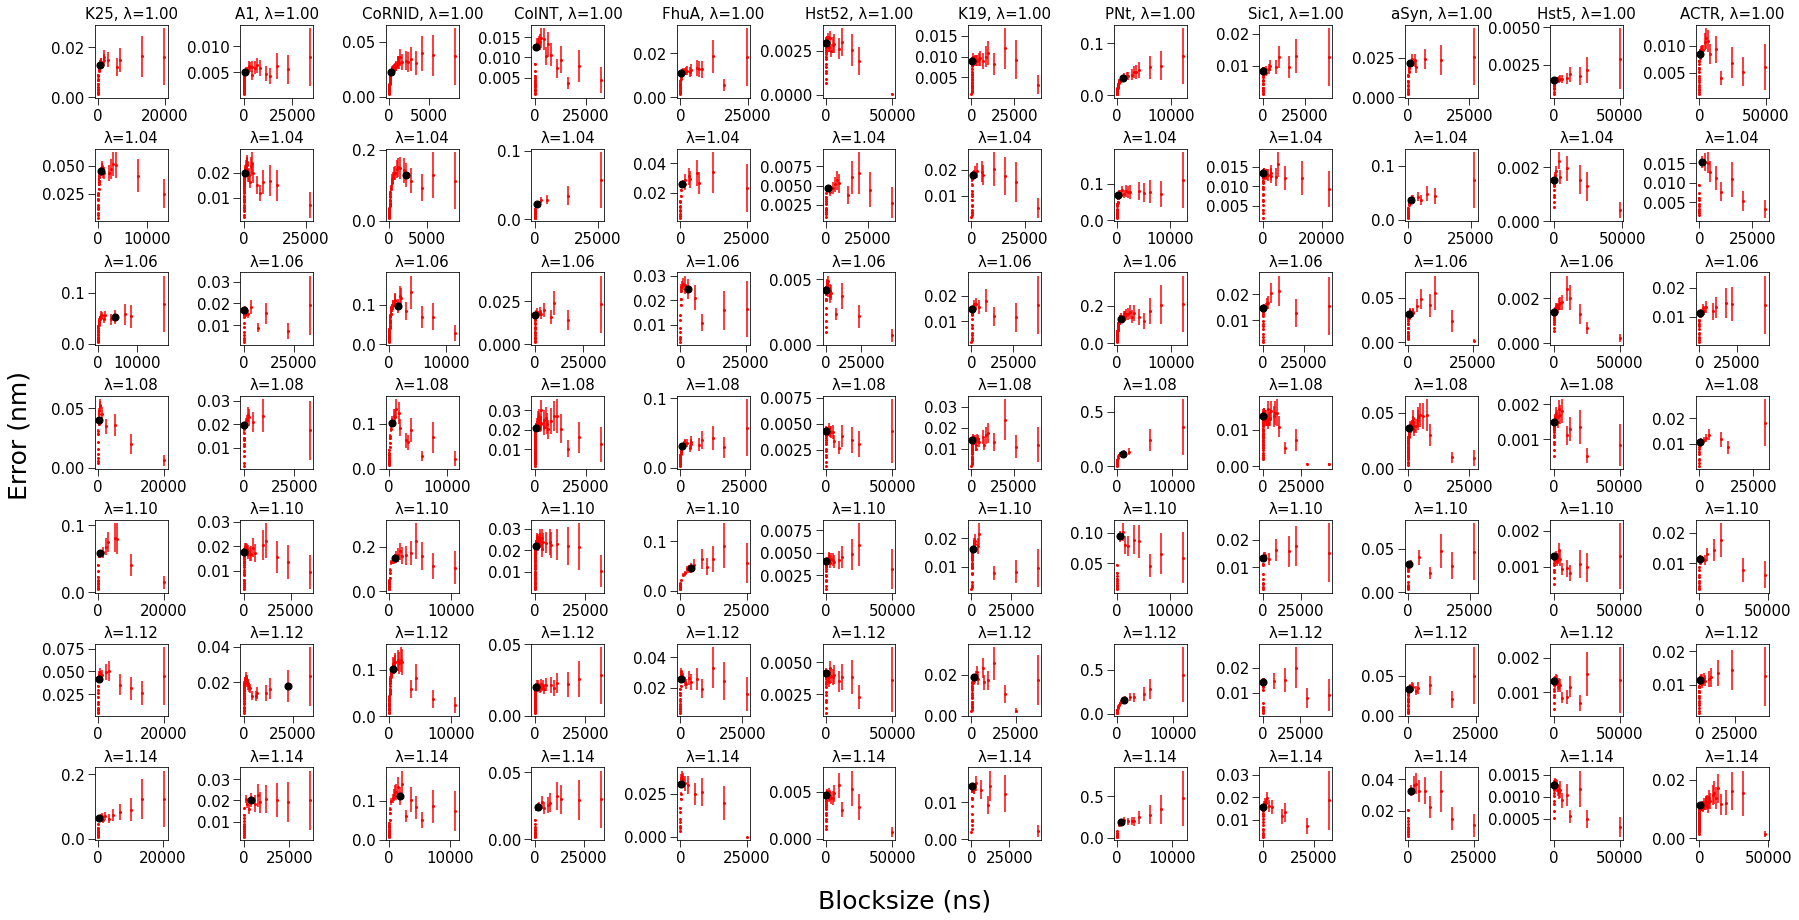

In [26]:
#Start plot
fig, ax = plt.subplots(figsize=(30,15), nrows=len(lambdas), ncols=len(proteins))    
plt.subplots_adjust(hspace = 0.70, wspace = 1.0)
fig.text(0.5, 0.08, 'Blocksize (ns)', ha='center', va='top', fontsize=25)
fig.text(0.09, 0.5, 'Error (nm)', ha='center', va='center', fontsize=25, rotation=90)
    
n = 0

#Loop over all proteins
for i in range(len(proteins)):
    
    k=0
    
    #Loop over all PW rescaling lambdas
    for l in lambdas:
        
        #Get Rg
        time, Rg = np.genfromtxt('%s/lambda_%s/Rg_gyrate.xvg' % (str(proteins[i]), str(l)), usecols=(0,1), skip_header=27, unpack=True)
        
        #Trim Rg array for block error analysis
        Rg = block.check(Rg, multi=1)
        
        #Block error analysis
        blocks_stat = block.blocking(Rg)
        
        #Choose optimal block size and find error
        if errmethod=='b3':
            corr_len, err = block.optimal_block(len(Rg),blocks_stat,method="b3")
        elif errmethod=='knee_loc':
            corr_len, err = block.optimal_block(len(Rg),blocks_stat,method="knee_loc",S=2.7)
        elif errmethod=='hline':
            corr_len, err = block.optimal_block(len(Rg),blocks_stat,method="hline")
        
        #Plot
        ax[k,n].errorbar(blocks_stat[...,0],blocks_stat[...,1],blocks_stat[...,2],fmt='ro',ms=2)
        ax[k,n].tick_params(colors='black', direction='out', length=7, labelsize=15)
        
        #Set title for top row
        if k == 0:
            ax[k,n].set_title('%s, λ=%s' % (str(proteins[i]), str(l)), fontsize=15)
        #Set title for other rows 
        else:
            ax[k,n].set_title('λ=%s' % str(l), fontsize=15)
        
        #Plot chosen block-size and error
        ax[k,n].scatter(corr_len,err,c='k',zorder=300,s=50)
        
        k+=1
    n+=1

#Save figure
fig.savefig("figures/Rg_blockerror.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("figures/Rg_blockerror.pdf", bbox_inches='tight', pad_inches=1, dpi=400)